## DIAMOND PRICE PREDICTION

#### Let's import the libraries we'll use

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor

import seaborn as sns

import xgboost as xg
from xgboost import XGBRegressor

#### Import the diamond data set

In [2]:
diamonds_train = pd.read_csv('/home/julian/Cursos/Ironhack/Proyectos/Proyecto5/Diamond-Price-Prediction/train.csv')

In [3]:
diamonds_test = pd.read_csv('/home/julian/Cursos/Ironhack/Proyectos/Proyecto5/Diamond-Price-Prediction/test.csv')

### EXPLORATORY DATA ANALYSIS

In [10]:
diamonds_train.shape

(40455, 11)

In [11]:
diamonds_train.head(3)

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983


In [12]:
diamonds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       40455 non-null  int64  
 1   carat    40455 non-null  float64
 2   cut      40455 non-null  object 
 3   color    40455 non-null  object 
 4   clarity  40455 non-null  object 
 5   depth    40455 non-null  float64
 6   table    40455 non-null  float64
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
 10  price    40455 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 3.4+ MB


In [13]:
diamonds_train.dtypes

id           int64
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price      float64
dtype: object

In [8]:
diamonds_train_corr = diamonds_train.corr()
diamonds_train_corr

,id,carat,depth,table,x,y,z,price
id,1.000000,-0.003045,-0.000405,0.000783,-0.002447,-0.001936,-0.001273,-0.003194
carat,-0.003045,1.000000,0.023585,0.185478,0.974648,0.944419,0.947469,0.920064
depth,-0.000405,0.023585,1.000000,-0.299203,-0.029867,-0.033960,0.089474,-0.003292
table,0.000783,0.185478,-0.299203,1.000000,0.200374,0.186788,0.153726,0.162804
x,-0.002447,0.974648,-0.029867,0.200374,1.000000,0.967315,0.965496,0.957668
y,-0.001936,0.944419,-0.033960,0.186788,0.967315,1.000000,0.941176,0.928909
z,-0.001273,0.947469,0.089474,0.153726,0.965496,0.941176,1.000000,0.930014
price,-0.003194,0.920064,-0.003292,0.162804,0.957668,0.928909,0.930014,1.000000


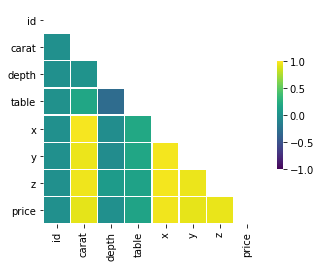

In [9]:
mascara = np.triu(np.ones_like(diamonds_train_corr, dtype=bool))
color_map = sns.diverging_palette(0, 10, as_cmap=True) 

sns.heatmap(diamonds_train_corr, 
            mask=mascara,
            cmap="viridis",
            vmax=1,
            vmin=-1,
            square=True, 
            linewidth=.5, 
            cbar_kws={"shrink": .5} 
);

#### CATEGORICAL FEATURES

#### We encoded manually the categorical values in order to preserve their order importance

In [14]:
diamonds_train.cut.value_counts()

Ideal        16230
Premium      10338
Very Good     9003
Good          3682
Fair          1202
Name: cut, dtype: int64

In [15]:
dic_cut = {'Ideal': '1', 'Premium': '2', 'Very Good': '3', 'Good': '4', 'Fair': '5'}

In [16]:
diamonds_train.cut = diamonds_train.cut.map(dic_cut)

#### COLOR IS MORE IMPORTANT THAN CLARITY (ojo)

In [17]:
diamonds_train.color.value_counts()

G    8410
E    7368
F    7182
H    6203
D    5100
I    4070
J    2122
Name: color, dtype: int64

In [18]:
#THE COLOR SCALE STARTS AT D, WICH IS NOT TOP QUALITY

In [19]:
dic_color = {'D': '1', 'E': '2', 'F': '3', 'G': '4', 'H': '5', 'I': '6', 'J': '7'}

In [20]:
diamonds_train.color = diamonds_train.color.map(dic_color)

In [21]:
diamonds_train.color.value_counts()

4    8410
2    7368
3    7182
5    6203
1    5100
6    4070
7    2122
Name: color, dtype: int64

In [22]:
diamonds_train.clarity.unique()

array(['SI2', 'VVS2', 'VS2', 'VS1', 'SI1', 'VVS1', 'IF', 'I1'],
      dtype=object)

In [23]:
dic_clarity = {'I1': '1', 'SI2': '2', 'SI1': '3', 'VS2': '4', 'VS1': '5', 'VVS2': '6', 'VVS1': '7', 'IF': '8'}

In [24]:
diamonds_train.clarity = diamonds_train.clarity.map(dic_clarity)

In [25]:
diamonds_train.head(3)

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.30,2,1,2,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,1,2,6,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,1,3,4,61.8,59.0,5.71,5.74,3.54,7.983


### MODEL TRAINING

#### We prepared the data for training and testing of the candidates models:

In [26]:
X = diamonds_train.drop('price', axis=1)

In [27]:
y = diamonds_train.price

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Linear Model

In [30]:
linear_model = LinearRegression()

In [31]:
linear_model.fit(X_train,y_train)

LinearRegression()

In [36]:
y_test_pred = linear_model.predict(X_test)

In [39]:
RMSE = (mean_squared_error(y_test, y_test_pred)) ** 0.5
RMSE

0.16086233537337213

#### Let's keep the variables that are highly correlated with the target variable and refit the model

In [40]:
X.drop(columns=['id', 'depth', 'table'], inplace=True)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
linear_model.fit(X_train,y_train)

LinearRegression()

In [44]:
y_test_pred = linear_model.predict(X_test)

In [45]:
RMSE = (mean_squared_error(y_test, y_test_pred)) ** 0.5
RMSE

0.19136805027447726

#### We didn't get an improvement, maybe because of colinearity between some of the variables or the fact that the target variable it doesn't look to be normaly distributed

<AxesSubplot:xlabel='price', ylabel='Count'>

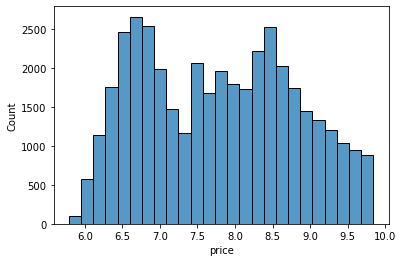

In [47]:
sns.histplot(y, bins=25)

### Decision Tree Regression

#### After fitting descicion trees with different depth levels, we saw good results for depths from 11 to 15

In [48]:
tree_model = DecisionTreeRegressor(max_depth=15)

In [67]:
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15)

In [68]:
y_test_pred = tree_model.predict(X_test)

In [71]:
RSME = (mean_squared_error(y_test, y_test_pred)) ** 0.5
RSME

0.11877506649636752

#### We can see a better performance than the one we got with the linear model but let's try to choose a better parameter setting with a Grid Search for different depths and minimun sample splits.

In [75]:
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid={
        "max_depth": [11, 12, 13, 14, 15],
        "min_samples_split": [30, 50, 70, 100],
    },
    cv=10,
    verbose=1,
    scoring="neg_root_mean_squared_error",
    return_train_score=True
)

In [76]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [11, 12, 13, 14, 15],
                         'min_samples_split': [30, 50, 70, 100]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

In [78]:
best_tree = grid_search.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=15, min_samples_split=30)

In [79]:
tree_model_ = DecisionTreeRegressor(max_depth=15, min_samples_split=30)

In [80]:
tree_model_.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15, min_samples_split=30)

In [81]:
y_test_pred = tree_model_.predict(X_test)

In [82]:
RSME = (mean_squared_error(y_test, y_test_pred)) ** 0.5
RSME

0.10784113029543375

#### We got an improvement in the performance metric, but we can still get advantage from a different approach

### Random Forest

#### Let's train a random forest using the decision tree regression parameters that we got in our grid search. We'll build a 50 trees random forest

In [83]:
random_forest = RandomForestRegressor(n_estimators=50, max_features=8, max_depth=15, min_samples_split=30)

In [84]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features=8, min_samples_split=30,
                      n_estimators=50)

In [85]:
y_test_pred = random_forest.predict(X_test)

In [86]:
RSME = (mean_squared_error(y_test, y_test_pred)) ** 0.5
RSME

0.09341492632238078

#### Naturally, the performance of the random forest was better than with a single tree, but we can still improve the metric by optimally choosing our hyperparameters via a Randomized Search

In [87]:
randomized_search = RandomizedSearchCV(
                    estimator=RandomForestRegressor(),
                    param_distributions={
                    'bootstrap': [True, False],
                    'max_depth': [10, 11, 12, 13, 14, 15, 16, None],
                    'max_features': [5, 6, 7, 8, 9],
                    'min_samples_split': [15, 30, 50],
                    'n_estimators': [50, 100, 150]
                     },
                    n_iter=100,
                    cv=10,
                    verbose=2,
                    scoring="neg_root_mean_squared_error",
                    return_train_score=True
                    )

In [ ]:
%%time
randomized_search.fit(X_train, y_train)

In [ ]:
best_ranf = randomized_search.best_estimator_
best_ranf

#### Now we'll fit a random forest with the hyperparameters obtained in the randomized search

In [89]:
random_forest_ = RandomForestRegressor(bootstrap=False, max_depth=16, max_features=5, min_samples_split=15, n_estimators=150)

In [90]:
random_forest_.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=16, max_features=5,
                      min_samples_split=15, n_estimators=150)

In [91]:
y_test_pred = random_forest_.predict(X_test)

In [92]:
RSME = (mean_squared_error(y_test, y_test_pred)) ** 0.5
RSME

0.09065894384729493

#### Our optimized Random Forest got a better performance than the last one. But we'll take advantage of more powerfull algorithm, the XGBoost

###  XGBoost trained Random Forest

#### Firstly we'll transform the values of the categorical variables to make them suitable for the XGBoost algorithm. Also, we'll make use of the matrix structure from the xgboost library

In [28]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()

In [31]:
X_train['cut'] = lbl.fit_transform(X_train['cut'].astype(str))
X_train['color'] = lbl.fit_transform(X_train['color'].astype(str))
X_train['clarity'] = lbl.fit_transform(X_train['clarity'].astype(str))

<ipython-input-31-41c8d66383be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['cut'] = lbl.fit_transform(X_train['cut'].astype(str))
<ipython-input-31-41c8d66383be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['color'] = lbl.fit_transform(X_train['color'].astype(str))
<ipython-input-31-41c8d66383be>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [32]:
X_test['cut'] = lbl.fit_transform(X_test['cut'].astype(str))
X_test['color'] = lbl.fit_transform(X_test['color'].astype(str))
X_test['clarity'] = lbl.fit_transform(X_test['clarity'].astype(str))

<ipython-input-32-6b48c5ad10ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['cut'] = lbl.fit_transform(X_test['cut'].astype(str))
<ipython-input-32-6b48c5ad10ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['color'] = lbl.fit_transform(X_test['color'].astype(str))
<ipython-input-32-6b48c5ad10ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [33]:
train_dmatrix = xg.DMatrix(data=X_train, label=y_train, enable_categorical=True)

In [34]:
test_dmatrix = xg.DMatrix(data =X_test, label=y_test, enable_categorical=True)

In [27]:
params = {'booster':'gbtree', 
  'objective':'reg:linear', 
  'colsample_bynode': 0.8,
  'learning_rate': 0.3,
  'max_depth': 15,
  'num_parallel_tree': 50,
  'subsample': 0.8,
  'tree_method': 'auto',
  'verbosity': 1}

In [28]:
xgb_reg = xg.train(params = params, dtrain = train_dmatrix, num_boost_round = 50)

[11:58:18] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:58:18] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[11:58:19] INFO: ../src/t

[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=7
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=7
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=7
[11:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[11:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=9
[11:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=7
[11:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=9
[11:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=7
[11:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=8
[11:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=8
[11:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=8
[11:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=8
[11:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned n

[11:58:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=11
[11:58:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=11
[11:58:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=14
[11:58:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=14
[11:58:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=11
[11:58:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=11
[11:58:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=12
[11:58:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=13
[11:58:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra n

[11:58:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 560 extra nodes, 0 pruned nodes, max_depth=15
[11:58:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 646 extra nodes, 0 pruned nodes, max_depth=15
[11:58:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 688 extra nodes, 0 pruned nodes, max_depth=15
[11:58:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 652 extra nodes, 0 pruned nodes, max_depth=15
[11:58:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 636 extra nodes, 0 pruned nodes, max_depth=15
[11:58:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 668 extra nodes, 0 pruned nodes, max_depth=15
[11:58:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 550 extra nodes, 0 pruned nodes, max_depth=15
[11:58:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 552 extra nodes, 0 pruned nodes, max_depth=15
[11:58:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 620 extra n

[11:58:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2018 extra nodes, 0 pruned nodes, max_depth=15
[11:58:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2140 extra nodes, 0 pruned nodes, max_depth=15
[11:58:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2196 extra nodes, 0 pruned nodes, max_depth=15
[11:58:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2306 extra nodes, 0 pruned nodes, max_depth=15
[11:58:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1838 extra nodes, 0 pruned nodes, max_depth=15
[11:58:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2136 extra nodes, 0 pruned nodes, max_depth=15
[11:58:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1972 extra nodes, 0 pruned nodes, max_depth=15
[11:58:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2402 extra nodes, 0 pruned nodes, max_depth=15
[11:58:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204

[11:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3576 extra nodes, 0 pruned nodes, max_depth=15
[11:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4236 extra nodes, 0 pruned nodes, max_depth=15
[11:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4212 extra nodes, 0 pruned nodes, max_depth=15
[11:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3770 extra nodes, 0 pruned nodes, max_depth=15
[11:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4052 extra nodes, 0 pruned nodes, max_depth=15
[11:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4218 extra nodes, 0 pruned nodes, max_depth=15
[11:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3766 extra nodes, 0 pruned nodes, max_depth=15
[11:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3786 extra nodes, 0 pruned nodes, max_depth=15
[11:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 439

[11:58:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4106 extra nodes, 0 pruned nodes, max_depth=15
[11:58:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5456 extra nodes, 0 pruned nodes, max_depth=15
[11:58:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5000 extra nodes, 0 pruned nodes, max_depth=15
[11:58:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5048 extra nodes, 0 pruned nodes, max_depth=15
[11:58:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5126 extra nodes, 0 pruned nodes, max_depth=15
[11:58:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3622 extra nodes, 0 pruned nodes, max_depth=15
[11:58:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5000 extra nodes, 0 pruned nodes, max_depth=15
[11:58:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4586 extra nodes, 0 pruned nodes, max_depth=15
[11:58:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 407

[11:58:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3020 extra nodes, 0 pruned nodes, max_depth=15
[11:58:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3726 extra nodes, 0 pruned nodes, max_depth=15
[11:58:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4126 extra nodes, 0 pruned nodes, max_depth=15
[11:58:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3854 extra nodes, 0 pruned nodes, max_depth=15
[11:58:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4410 extra nodes, 0 pruned nodes, max_depth=15
[11:58:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3804 extra nodes, 0 pruned nodes, max_depth=15
[11:58:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4634 extra nodes, 0 pruned nodes, max_depth=15
[11:58:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5422 extra nodes, 0 pruned nodes, max_depth=15
[11:58:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 442

[11:58:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3136 extra nodes, 0 pruned nodes, max_depth=15
[11:58:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3142 extra nodes, 0 pruned nodes, max_depth=15
[11:58:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3744 extra nodes, 0 pruned nodes, max_depth=15
[11:58:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4182 extra nodes, 0 pruned nodes, max_depth=15
[11:58:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3512 extra nodes, 0 pruned nodes, max_depth=15
[11:58:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3690 extra nodes, 0 pruned nodes, max_depth=15
[11:58:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3172 extra nodes, 0 pruned nodes, max_depth=15
[11:58:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3442 extra nodes, 0 pruned nodes, max_depth=15
[11:58:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308

[11:58:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1756 extra nodes, 0 pruned nodes, max_depth=15
[11:58:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2734 extra nodes, 0 pruned nodes, max_depth=15
[11:58:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3380 extra nodes, 0 pruned nodes, max_depth=15
[11:58:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2818 extra nodes, 0 pruned nodes, max_depth=15
[11:58:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2936 extra nodes, 0 pruned nodes, max_depth=15
[11:58:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4264 extra nodes, 0 pruned nodes, max_depth=15
[11:58:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2776 extra nodes, 0 pruned nodes, max_depth=15
[11:58:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2698 extra nodes, 0 pruned nodes, max_depth=15
[11:58:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 273

[11:58:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3032 extra nodes, 0 pruned nodes, max_depth=15
[11:58:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3302 extra nodes, 0 pruned nodes, max_depth=15
[11:58:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3078 extra nodes, 0 pruned nodes, max_depth=15
[11:58:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2394 extra nodes, 0 pruned nodes, max_depth=15
[11:58:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2350 extra nodes, 0 pruned nodes, max_depth=15
[11:58:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3280 extra nodes, 0 pruned nodes, max_depth=15
[11:58:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2706 extra nodes, 0 pruned nodes, max_depth=15
[11:58:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1910 extra nodes, 0 pruned nodes, max_depth=15
[11:58:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 285

[11:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4140 extra nodes, 0 pruned nodes, max_depth=15
[11:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2222 extra nodes, 0 pruned nodes, max_depth=15
[11:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2616 extra nodes, 0 pruned nodes, max_depth=15
[11:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1600 extra nodes, 0 pruned nodes, max_depth=15
[11:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1854 extra nodes, 0 pruned nodes, max_depth=15
[11:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4224 extra nodes, 0 pruned nodes, max_depth=15
[11:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2560 extra nodes, 0 pruned nodes, max_depth=15
[11:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3926 extra nodes, 0 pruned nodes, max_depth=15
[11:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 289

[11:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4276 extra nodes, 0 pruned nodes, max_depth=15
[11:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2312 extra nodes, 0 pruned nodes, max_depth=15
[11:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5448 extra nodes, 0 pruned nodes, max_depth=15
[11:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4626 extra nodes, 0 pruned nodes, max_depth=15
[11:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1416 extra nodes, 0 pruned nodes, max_depth=15
[11:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4348 extra nodes, 0 pruned nodes, max_depth=15
[11:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3246 extra nodes, 0 pruned nodes, max_depth=15
[11:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2956 extra nodes, 0 pruned nodes, max_depth=15
[11:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 181

[11:58:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2422 extra nodes, 0 pruned nodes, max_depth=15
[11:58:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3338 extra nodes, 0 pruned nodes, max_depth=15
[11:58:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4064 extra nodes, 0 pruned nodes, max_depth=15
[11:58:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3206 extra nodes, 0 pruned nodes, max_depth=15
[11:58:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2214 extra nodes, 0 pruned nodes, max_depth=15
[11:58:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4824 extra nodes, 0 pruned nodes, max_depth=15
[11:58:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2964 extra nodes, 0 pruned nodes, max_depth=15
[11:58:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3524 extra nodes, 0 pruned nodes, max_depth=15
[11:58:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 723

[11:58:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2668 extra nodes, 0 pruned nodes, max_depth=15
[11:58:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1744 extra nodes, 0 pruned nodes, max_depth=15
[11:58:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1742 extra nodes, 0 pruned nodes, max_depth=15
[11:58:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3974 extra nodes, 0 pruned nodes, max_depth=15
[11:58:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3246 extra nodes, 0 pruned nodes, max_depth=15
[11:58:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1728 extra nodes, 0 pruned nodes, max_depth=15
[11:58:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3506 extra nodes, 0 pruned nodes, max_depth=15
[11:58:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3604 extra nodes, 0 pruned nodes, max_depth=15
[11:58:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248

[11:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3616 extra nodes, 0 pruned nodes, max_depth=15
[11:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2310 extra nodes, 0 pruned nodes, max_depth=15
[11:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3982 extra nodes, 0 pruned nodes, max_depth=15
[11:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4140 extra nodes, 0 pruned nodes, max_depth=15
[11:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4806 extra nodes, 0 pruned nodes, max_depth=15
[11:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1664 extra nodes, 0 pruned nodes, max_depth=15
[11:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2322 extra nodes, 0 pruned nodes, max_depth=15
[11:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4932 extra nodes, 0 pruned nodes, max_depth=15
[11:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 333

[11:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4052 extra nodes, 0 pruned nodes, max_depth=15
[11:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4776 extra nodes, 0 pruned nodes, max_depth=15
[11:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5270 extra nodes, 0 pruned nodes, max_depth=15
[11:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2674 extra nodes, 0 pruned nodes, max_depth=15
[11:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3348 extra nodes, 0 pruned nodes, max_depth=15
[11:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2874 extra nodes, 0 pruned nodes, max_depth=15
[11:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2892 extra nodes, 0 pruned nodes, max_depth=15
[11:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2586 extra nodes, 0 pruned nodes, max_depth=15
[11:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 440

[11:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3850 extra nodes, 0 pruned nodes, max_depth=15
[11:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3930 extra nodes, 0 pruned nodes, max_depth=15
[11:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4412 extra nodes, 0 pruned nodes, max_depth=15
[11:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3744 extra nodes, 0 pruned nodes, max_depth=15
[11:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2540 extra nodes, 0 pruned nodes, max_depth=15
[11:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3810 extra nodes, 0 pruned nodes, max_depth=15
[11:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2818 extra nodes, 0 pruned nodes, max_depth=15
[11:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3838 extra nodes, 0 pruned nodes, max_depth=15
[11:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 259

[11:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5018 extra nodes, 0 pruned nodes, max_depth=15
[11:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4068 extra nodes, 0 pruned nodes, max_depth=15
[11:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3950 extra nodes, 0 pruned nodes, max_depth=15
[11:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3650 extra nodes, 0 pruned nodes, max_depth=15
[11:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4354 extra nodes, 0 pruned nodes, max_depth=15
[11:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2744 extra nodes, 0 pruned nodes, max_depth=15
[11:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3106 extra nodes, 0 pruned nodes, max_depth=15
[11:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4054 extra nodes, 0 pruned nodes, max_depth=15
[11:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 369

[11:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3128 extra nodes, 0 pruned nodes, max_depth=15
[11:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2374 extra nodes, 0 pruned nodes, max_depth=15
[11:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4262 extra nodes, 0 pruned nodes, max_depth=15
[11:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3438 extra nodes, 0 pruned nodes, max_depth=15
[11:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2228 extra nodes, 0 pruned nodes, max_depth=15
[11:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4366 extra nodes, 0 pruned nodes, max_depth=15
[11:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4354 extra nodes, 0 pruned nodes, max_depth=15
[11:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3772 extra nodes, 0 pruned nodes, max_depth=15
[11:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 414

[11:59:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3988 extra nodes, 0 pruned nodes, max_depth=15
[11:59:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2714 extra nodes, 0 pruned nodes, max_depth=15
[11:59:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2636 extra nodes, 0 pruned nodes, max_depth=15
[11:59:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5334 extra nodes, 0 pruned nodes, max_depth=15
[11:59:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3992 extra nodes, 0 pruned nodes, max_depth=15
[11:59:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3684 extra nodes, 0 pruned nodes, max_depth=15
[11:59:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3772 extra nodes, 0 pruned nodes, max_depth=15
[11:59:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1588 extra nodes, 0 pruned nodes, max_depth=15
[11:59:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 223

[11:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4416 extra nodes, 0 pruned nodes, max_depth=15
[11:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4548 extra nodes, 0 pruned nodes, max_depth=15
[11:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6222 extra nodes, 0 pruned nodes, max_depth=15
[11:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2608 extra nodes, 0 pruned nodes, max_depth=15
[11:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3852 extra nodes, 0 pruned nodes, max_depth=15
[11:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5514 extra nodes, 0 pruned nodes, max_depth=15
[11:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2288 extra nodes, 0 pruned nodes, max_depth=15
[11:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3124 extra nodes, 0 pruned nodes, max_depth=15
[11:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 411

[11:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3492 extra nodes, 0 pruned nodes, max_depth=15
[11:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5198 extra nodes, 0 pruned nodes, max_depth=15
[11:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2962 extra nodes, 0 pruned nodes, max_depth=15
[11:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4846 extra nodes, 0 pruned nodes, max_depth=15
[11:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4550 extra nodes, 0 pruned nodes, max_depth=15
[11:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4398 extra nodes, 0 pruned nodes, max_depth=15
[11:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1180 extra nodes, 0 pruned nodes, max_depth=15
[11:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5854 extra nodes, 0 pruned nodes, max_depth=15
[11:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 518

[11:59:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2020 extra nodes, 0 pruned nodes, max_depth=15
[11:59:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2118 extra nodes, 0 pruned nodes, max_depth=15
[11:59:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2840 extra nodes, 0 pruned nodes, max_depth=15
[11:59:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3298 extra nodes, 0 pruned nodes, max_depth=15
[11:59:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4944 extra nodes, 0 pruned nodes, max_depth=15
[11:59:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1916 extra nodes, 0 pruned nodes, max_depth=15
[11:59:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2016 extra nodes, 0 pruned nodes, max_depth=15
[11:59:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6422 extra nodes, 0 pruned nodes, max_depth=15
[11:59:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 245

[11:59:43] ======== Monitor: Learner ========
[11:59:43] Configure: 0s, 1 calls @ 0us

[11:59:43] EvalOneIter: 0.003126s, 50 calls @ 3126us

[11:59:43] GetGradient: 0.018134s, 50 calls @ 18134us

[11:59:43] PredictRaw: 0.925842s, 50 calls @ 925842us

[11:59:43] UpdateOneIter: 64.2331s, 50 calls @ 64233100us

[11:59:43] ======== Monitor: GBTree ========
[11:59:43] BoostNewTrees: 63.655s, 50 calls @ 63655015us

[11:59:43] CommitModel: 9.3e-05s, 50 calls @ 93us

[11:59:43] ======== Monitor: TreePruner ========
[11:59:43] PrunerUpdate: 0.399975s, 50 calls @ 399975us



In [29]:
y_test_pred = xgb_reg.predict(test_dmatrix)

In [30]:
RSME = (mean_squared_error(y_test, y_test_pred)) ** 0.5
RSME

0.0852532752097859

#### Finally we got the better performance metric for the models tested, by building a 50 trees random forest boosted through 50 iterations of the XGBoost algorithm, with a learning rate of 0.3 . For each tree, we set a maximun depth of 50 levels, We could still get a better performance by tuning our hyperparameters by a randomized search.

### Now, with the chosen model, we'll train it using the full test set

In [32]:
X['cut'] = lbl.fit_transform(X['cut'].astype(str))
X['color'] = lbl.fit_transform(X['color'].astype(str))
X['clarity'] = lbl.fit_transform(X['clarity'].astype(str))

In [33]:
fulltrain_dmatrix = xg.DMatrix(data=X, label=y, enable_categorical=True)

In [34]:
xgb_reg = xg.train(params = params, dtrain = fulltrain_dmatrix, num_boost_round = 50)

[12:02:57] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:57] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[12:02:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=7
[12:02:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=7
[12:02:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:02:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:02:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:02:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:02:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:02:57] INFO: ../src/t

[12:02:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:02:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:02:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:02:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[12:02:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:02:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:02:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:02:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:02:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[12:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=8
[12:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=8
[12:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=8
[12:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pr

[12:03:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=14
[12:03:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=15
[12:03:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=15
[12:03:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=15
[12:03:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=15
[12:03:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=15
[12:03:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=14
[12:03:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=13
[12:03:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra n

[12:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 682 extra nodes, 0 pruned nodes, max_depth=15
[12:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 652 extra nodes, 0 pruned nodes, max_depth=15
[12:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 602 extra nodes, 0 pruned nodes, max_depth=15
[12:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 748 extra nodes, 0 pruned nodes, max_depth=15
[12:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 656 extra nodes, 0 pruned nodes, max_depth=15
[12:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 664 extra nodes, 0 pruned nodes, max_depth=15
[12:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 658 extra nodes, 0 pruned nodes, max_depth=15
[12:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 712 extra nodes, 0 pruned nodes, max_depth=15
[12:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 710 extra n

[12:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2482 extra nodes, 0 pruned nodes, max_depth=15
[12:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2602 extra nodes, 0 pruned nodes, max_depth=15
[12:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2480 extra nodes, 0 pruned nodes, max_depth=15
[12:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2410 extra nodes, 0 pruned nodes, max_depth=15
[12:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2122 extra nodes, 0 pruned nodes, max_depth=15
[12:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2446 extra nodes, 0 pruned nodes, max_depth=15
[12:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2624 extra nodes, 0 pruned nodes, max_depth=15
[12:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2664 extra nodes, 0 pruned nodes, max_depth=15
[12:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 249

[12:03:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4390 extra nodes, 0 pruned nodes, max_depth=15
[12:03:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4302 extra nodes, 0 pruned nodes, max_depth=15
[12:03:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5474 extra nodes, 0 pruned nodes, max_depth=15
[12:03:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4262 extra nodes, 0 pruned nodes, max_depth=15
[12:03:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4322 extra nodes, 0 pruned nodes, max_depth=15
[12:03:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4070 extra nodes, 0 pruned nodes, max_depth=15
[12:03:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4366 extra nodes, 0 pruned nodes, max_depth=15
[12:03:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5132 extra nodes, 0 pruned nodes, max_depth=15
[12:03:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 482

[12:03:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5416 extra nodes, 0 pruned nodes, max_depth=15
[12:03:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4676 extra nodes, 0 pruned nodes, max_depth=15
[12:03:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5068 extra nodes, 0 pruned nodes, max_depth=15
[12:03:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5294 extra nodes, 0 pruned nodes, max_depth=15
[12:03:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5002 extra nodes, 0 pruned nodes, max_depth=15
[12:03:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4950 extra nodes, 0 pruned nodes, max_depth=15
[12:03:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5714 extra nodes, 0 pruned nodes, max_depth=15
[12:03:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5734 extra nodes, 0 pruned nodes, max_depth=15
[12:03:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 438

[12:03:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5566 extra nodes, 0 pruned nodes, max_depth=15
[12:03:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4604 extra nodes, 0 pruned nodes, max_depth=15
[12:03:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5050 extra nodes, 0 pruned nodes, max_depth=15
[12:03:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5088 extra nodes, 0 pruned nodes, max_depth=15
[12:03:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3572 extra nodes, 0 pruned nodes, max_depth=15
[12:03:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3908 extra nodes, 0 pruned nodes, max_depth=15
[12:03:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3852 extra nodes, 0 pruned nodes, max_depth=15
[12:03:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4960 extra nodes, 0 pruned nodes, max_depth=15
[12:03:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 349

[12:03:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3154 extra nodes, 0 pruned nodes, max_depth=15
[12:03:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5030 extra nodes, 0 pruned nodes, max_depth=15
[12:03:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4342 extra nodes, 0 pruned nodes, max_depth=15
[12:03:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3304 extra nodes, 0 pruned nodes, max_depth=15
[12:03:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4730 extra nodes, 0 pruned nodes, max_depth=15
[12:03:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3988 extra nodes, 0 pruned nodes, max_depth=15
[12:03:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3344 extra nodes, 0 pruned nodes, max_depth=15
[12:03:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4216 extra nodes, 0 pruned nodes, max_depth=15
[12:03:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 277

[12:03:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3122 extra nodes, 0 pruned nodes, max_depth=15
[12:03:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5172 extra nodes, 0 pruned nodes, max_depth=15
[12:03:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3364 extra nodes, 0 pruned nodes, max_depth=15
[12:03:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3556 extra nodes, 0 pruned nodes, max_depth=15
[12:03:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2890 extra nodes, 0 pruned nodes, max_depth=15
[12:03:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2682 extra nodes, 0 pruned nodes, max_depth=15
[12:03:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2690 extra nodes, 0 pruned nodes, max_depth=15
[12:03:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5080 extra nodes, 0 pruned nodes, max_depth=15
[12:03:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 339

[12:03:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2058 extra nodes, 0 pruned nodes, max_depth=15
[12:03:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2386 extra nodes, 0 pruned nodes, max_depth=15
[12:03:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2844 extra nodes, 0 pruned nodes, max_depth=15
[12:03:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3460 extra nodes, 0 pruned nodes, max_depth=15
[12:03:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4334 extra nodes, 0 pruned nodes, max_depth=15
[12:03:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3086 extra nodes, 0 pruned nodes, max_depth=15
[12:03:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5288 extra nodes, 0 pruned nodes, max_depth=15
[12:03:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3838 extra nodes, 0 pruned nodes, max_depth=15
[12:03:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288

[12:03:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2900 extra nodes, 0 pruned nodes, max_depth=15
[12:03:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1726 extra nodes, 0 pruned nodes, max_depth=15
[12:03:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2738 extra nodes, 0 pruned nodes, max_depth=15
[12:03:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2784 extra nodes, 0 pruned nodes, max_depth=15
[12:03:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5874 extra nodes, 0 pruned nodes, max_depth=15
[12:03:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1844 extra nodes, 0 pruned nodes, max_depth=15
[12:03:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4188 extra nodes, 0 pruned nodes, max_depth=15
[12:03:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3400 extra nodes, 0 pruned nodes, max_depth=15
[12:03:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 558

[12:03:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4190 extra nodes, 0 pruned nodes, max_depth=15
[12:03:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3434 extra nodes, 0 pruned nodes, max_depth=15
[12:03:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2418 extra nodes, 0 pruned nodes, max_depth=15
[12:03:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3064 extra nodes, 0 pruned nodes, max_depth=15
[12:03:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2932 extra nodes, 0 pruned nodes, max_depth=15
[12:03:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3254 extra nodes, 0 pruned nodes, max_depth=15
[12:03:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4512 extra nodes, 0 pruned nodes, max_depth=15
[12:03:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3804 extra nodes, 0 pruned nodes, max_depth=15
[12:03:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272

[12:03:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6372 extra nodes, 0 pruned nodes, max_depth=15
[12:03:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2964 extra nodes, 0 pruned nodes, max_depth=15
[12:03:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3486 extra nodes, 0 pruned nodes, max_depth=15
[12:03:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4824 extra nodes, 0 pruned nodes, max_depth=15
[12:03:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3982 extra nodes, 0 pruned nodes, max_depth=15
[12:03:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3758 extra nodes, 0 pruned nodes, max_depth=15
[12:03:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3984 extra nodes, 0 pruned nodes, max_depth=15
[12:03:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3314 extra nodes, 0 pruned nodes, max_depth=15
[12:03:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 594

[12:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 7358 extra nodes, 0 pruned nodes, max_depth=15
[12:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4482 extra nodes, 0 pruned nodes, max_depth=15
[12:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1344 extra nodes, 0 pruned nodes, max_depth=15
[12:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2606 extra nodes, 0 pruned nodes, max_depth=15
[12:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3420 extra nodes, 0 pruned nodes, max_depth=15
[12:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4012 extra nodes, 0 pruned nodes, max_depth=15
[12:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1846 extra nodes, 0 pruned nodes, max_depth=15
[12:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3564 extra nodes, 0 pruned nodes, max_depth=15
[12:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 434

[12:03:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3842 extra nodes, 0 pruned nodes, max_depth=15
[12:03:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3744 extra nodes, 0 pruned nodes, max_depth=15
[12:03:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2596 extra nodes, 0 pruned nodes, max_depth=15
[12:03:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4048 extra nodes, 0 pruned nodes, max_depth=15
[12:03:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3156 extra nodes, 0 pruned nodes, max_depth=15
[12:03:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3066 extra nodes, 0 pruned nodes, max_depth=15
[12:03:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3556 extra nodes, 0 pruned nodes, max_depth=15
[12:03:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3968 extra nodes, 0 pruned nodes, max_depth=15
[12:03:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 217

[12:03:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3274 extra nodes, 0 pruned nodes, max_depth=15
[12:03:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3012 extra nodes, 0 pruned nodes, max_depth=15
[12:03:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4080 extra nodes, 0 pruned nodes, max_depth=15
[12:03:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 7652 extra nodes, 0 pruned nodes, max_depth=15
[12:03:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3096 extra nodes, 0 pruned nodes, max_depth=15
[12:03:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3060 extra nodes, 0 pruned nodes, max_depth=15
[12:03:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4112 extra nodes, 0 pruned nodes, max_depth=15
[12:03:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2710 extra nodes, 0 pruned nodes, max_depth=15
[12:03:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 301

[12:03:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2096 extra nodes, 0 pruned nodes, max_depth=15
[12:03:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5360 extra nodes, 0 pruned nodes, max_depth=15
[12:03:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6220 extra nodes, 0 pruned nodes, max_depth=15
[12:03:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3400 extra nodes, 0 pruned nodes, max_depth=15
[12:03:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5668 extra nodes, 0 pruned nodes, max_depth=15
[12:03:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1984 extra nodes, 0 pruned nodes, max_depth=15
[12:03:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2176 extra nodes, 0 pruned nodes, max_depth=15
[12:03:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1952 extra nodes, 0 pruned nodes, max_depth=15
[12:03:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 646

[12:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6216 extra nodes, 0 pruned nodes, max_depth=15
[12:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3714 extra nodes, 0 pruned nodes, max_depth=15
[12:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4246 extra nodes, 0 pruned nodes, max_depth=15
[12:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1398 extra nodes, 0 pruned nodes, max_depth=15
[12:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1866 extra nodes, 0 pruned nodes, max_depth=15
[12:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2980 extra nodes, 0 pruned nodes, max_depth=15
[12:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1270 extra nodes, 0 pruned nodes, max_depth=15
[12:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3816 extra nodes, 0 pruned nodes, max_depth=15
[12:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 336

[12:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4422 extra nodes, 0 pruned nodes, max_depth=15
[12:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4762 extra nodes, 0 pruned nodes, max_depth=15
[12:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4264 extra nodes, 0 pruned nodes, max_depth=15
[12:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2836 extra nodes, 0 pruned nodes, max_depth=15
[12:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4324 extra nodes, 0 pruned nodes, max_depth=15
[12:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4360 extra nodes, 0 pruned nodes, max_depth=15
[12:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3576 extra nodes, 0 pruned nodes, max_depth=15
[12:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2230 extra nodes, 0 pruned nodes, max_depth=15
[12:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 594

[12:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5588 extra nodes, 0 pruned nodes, max_depth=15
[12:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3594 extra nodes, 0 pruned nodes, max_depth=15
[12:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1300 extra nodes, 0 pruned nodes, max_depth=15
[12:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5670 extra nodes, 0 pruned nodes, max_depth=15
[12:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5632 extra nodes, 0 pruned nodes, max_depth=15
[12:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2460 extra nodes, 0 pruned nodes, max_depth=15
[12:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4110 extra nodes, 0 pruned nodes, max_depth=15
[12:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5856 extra nodes, 0 pruned nodes, max_depth=15
[12:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 493

[12:04:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3294 extra nodes, 0 pruned nodes, max_depth=15
[12:04:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2788 extra nodes, 0 pruned nodes, max_depth=15
[12:04:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4342 extra nodes, 0 pruned nodes, max_depth=15
[12:04:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3484 extra nodes, 0 pruned nodes, max_depth=15
[12:04:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 5190 extra nodes, 0 pruned nodes, max_depth=15
[12:04:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1902 extra nodes, 0 pruned nodes, max_depth=15
[12:04:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3142 extra nodes, 0 pruned nodes, max_depth=15
[12:04:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1396 extra nodes, 0 pruned nodes, max_depth=15
[12:04:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 348

[12:04:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4814 extra nodes, 0 pruned nodes, max_depth=15
[12:04:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4806 extra nodes, 0 pruned nodes, max_depth=15
[12:04:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2554 extra nodes, 0 pruned nodes, max_depth=15
[12:04:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2394 extra nodes, 0 pruned nodes, max_depth=15
[12:04:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2996 extra nodes, 0 pruned nodes, max_depth=15
[12:04:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3190 extra nodes, 0 pruned nodes, max_depth=15
[12:04:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2184 extra nodes, 0 pruned nodes, max_depth=15
[12:04:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4584 extra nodes, 0 pruned nodes, max_depth=15
[12:04:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 223

[12:04:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2898 extra nodes, 0 pruned nodes, max_depth=15
[12:04:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1206 extra nodes, 0 pruned nodes, max_depth=15
[12:04:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6280 extra nodes, 0 pruned nodes, max_depth=15
[12:04:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2868 extra nodes, 0 pruned nodes, max_depth=15
[12:04:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2724 extra nodes, 0 pruned nodes, max_depth=15
[12:04:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3624 extra nodes, 0 pruned nodes, max_depth=15
[12:04:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3364 extra nodes, 0 pruned nodes, max_depth=15
[12:04:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4240 extra nodes, 0 pruned nodes, max_depth=15
[12:04:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342

[12:04:45] ======== Monitor: Learner ========
[12:04:45] Configure: 0.000554s, 1 calls @ 554us

[12:04:45] EvalOneIter: 0.000211s, 50 calls @ 211us

[12:04:45] GetGradient: 0.053405s, 50 calls @ 53405us

[12:04:45] PredictRaw: 1.26805s, 50 calls @ 1268048us

[12:04:45] UpdateOneIter: 87.514s, 50 calls @ 87513971us

[12:04:45] ======== Monitor: GBTree ========
[12:04:45] BoostNewTrees: 86.1651s, 50 calls @ 86165126us

[12:04:45] CommitModel: 0.000115s, 50 calls @ 115us

[12:04:45] ======== Monitor: TreePruner ========
[12:04:45] PrunerUpdate: 0.419186s, 50 calls @ 419186us

[12:04:45] ======== Monitor: Learner ========
[12:04:45] Configure: 0.001132s, 1 calls @ 1132us

[12:04:45] ======== Monitor: GBTree ========
[12:04:45] ======== Monitor: TreePruner ========


#### We prepare the test data set to perform our price predicitons

In [43]:
diamonds_test.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,0,0.32,Ideal,I,SI1,60.5,58.0,4.43,4.49,2.70
1,1,1.24,Premium,I,SI1,62.9,60.0,6.80,6.74,4.26
2,2,1.66,Premium,D,SI1,62.0,59.0,7.55,7.60,4.70
3,3,0.75,Premium,D,SI2,60.6,56.0,5.94,5.90,3.59
4,4,1.50,Fair,E,SI2,64.8,55.0,7.26,7.15,4.67


In [44]:
diamonds_test.clarity = diamonds_test.clarity.map(dic_clarity)

In [45]:
diamonds_test.color = diamonds_test.color.map(dic_color)

In [46]:
diamonds_test.cut = diamonds_test.cut.map(dic_cut)

In [50]:
diamonds_test['cut'] = lbl.fit_transform(diamonds_test['cut'].astype(str))
diamonds_test['color'] = lbl.fit_transform(diamonds_test['color'].astype(str))
diamonds_test['clarity'] = lbl.fit_transform(diamonds_test['clarity'].astype(str))

In [51]:
diamonds_test_dmatrix = xg.DMatrix(data=diamonds_test, enable_categorical=True)

### Price predictions

In [52]:
y_price_pred = xgb_reg.predict(diamonds_test_dmatrix)

In [53]:
y_price_pred

array([6.057235 , 8.494676 , 9.387988 , ..., 6.4087543, 8.706489 ,
       7.9942145], dtype=float32)

In [54]:
diamonds_test['price'] = y_price_pred

In [55]:
diamonds_test.drop(columns=['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y',
       'z'], inplace=True)

In [56]:
diamonds_test

,id,price
0,0,6.057235
1,1,8.494676
2,2,9.387988
3,3,7.822424
4,4,8.915586
...,...,...
13480,13480,8.556455
13481,13481,8.404564
13482,13482,6.408754
13483,13483,8.706489


In [57]:
diamonds_test.to_csv('diamonds_xgb.csv', index = False)